In [ ]:
"""
Script for conducting negative binominal regression on number of encounter <= 5 yrs to death. 
In: 
    - gbddis_%s_%s.sas7bdat' %(disNr, yearY)
    - pc_gbd%s.sas7bdat' %(disNr)
    - so_gbd%s.sas7bdat' %(disNr)
    - si_gbd%s.sas7bdat' %(disNr)
Out: 
    -df_result_%s_dis%s_byIncome_last5_june23_v2_NBalph.xlsx

 Precuresor: SES_stratifiedHC_utilization_prior2death_june23.ipynb
By Pär,

"""

In [465]:
#pip install pyreadstat
#  from SES_stratifiedHC_utilization_nov22.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pyreadstat
import patsy
from patsy import dmatrices
import re
import pyreadstat
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as dm
import datetime as datetime
from datetime import datetime
import scipy.stats
import time # for sleep
import matplotlib as matplotlib
%matplotlib inline


In [3]:


dtchangedicCoD = {"LopNr":'int32',
                'ar':'int32',
                'FoddAr':'int32'}

dtchangedicIS = {"LopNr":'int32',
               'ar':'int32',
               "SI_u":'float16',
              "SI_e":'float16'}

dtchangedicOS = {"LopNr":'int32',
               'ar':'int32',
                "SO_u":'float16',
              "SO_e":'float16'}


dtchangedicPC = {"LopNr":'int32',
               'ar':'int32',
              "PC_u":'float16',
               "PC_e":'float16'}

In [5]:
from datetime import datetime

print("Current Time =", datetime.now().strftime("%H:%M:%S"))

Current Time = 14:20:32


# Negative binomial

In [318]:
def getNB2alpha(df, y_train, x_train, m):
    """
    
    df      -  to train/fit
    y_train -  
    x_train -  
    m  - patsy expression of model
    """
    outcome = y_train.columns[0] # e.g 'PC_e'

    df_t = df.copy()
    poisson_training_results = sm.GLM(y_train, x_train, family=sm.families.Poisson()).fit()
    
    df_t['LAMBDA'] = poisson_training_results.mu
    df_t['AUX_OLS_DEP'] = df_t.apply(lambda x: ((x[outcome] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)
    #use patsy to form the model specification for the OLSR
    ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
    #Configure and fit the OLSR model
    aux_olsr_results = smf.ols(ols_expr, df_t).fit()
    alpha = aux_olsr_results.params[0]
    return alpha

    
    

## NB with estimated alpha

In [319]:
#NEW with NB
# Loop over year 2018-2008, plot previous years of dis
"""
Create disease and data type specific excelfiles of betas of how income group predict number of health care encouters 5 yrs prior to death. Provide 4 models, with different regressors.  

In: 
    - gbddis_DISX_YEARY.sas7bdat
Out: 
    -"df_result_%s_dis%s_byIncome_last5_feb23_v5.xlsx' 

"""

print("Current Time =", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

gbdNr2namedic ={8:"Neoplasm",9:'Cardiovascular',19:'Musculoskeletal',13:'Mental',12:'Neurological' , 
                10:'Chronic_respiratory' , 15: 'Diabetes', 23: 'Self-harm_violence', 100: 'All'}

# sync these 2 lists
# OBSchange back to full list
outcomevarModelList = ["encAllHC"]#,"PC_e", "SO_e", "SI_e"] #["encAllHC", "PC_e", "SO_e", "SI_e"]
outcomevarLinePlot= ["PC_ePercapita", "SO_ePercapita", "SI_ePercapita"]#["AllHCEncPercapita", "PC_ePercapita", "SO_ePercapita", "SI_ePercapita"]

yearList =[2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008] #list of death years
disList = [ 8, 12,10, 15,100, 9] #15]#[12, 10, 15]#[9, 8]#,12, 10, 15]#, 23]#,13]#, 19]

 #change (yearList[:2], 
for disNr in disList: 

    #load HC
    #df_pc 
    fp_pc = 'P:\SBDD\Projects\SES\PC25GBDfile\pc_gbd%s.sas7bdat' %(disNr)
    df_pc, meta = pyreadstat.read_sas7bdat(fp_pc, encoding="LATIN1", )

    #df_os
    fp_os = r'P:\SBDD\Projects\SES\NPR25GBDfiles\so_gbd%s.sas7bdat' %(disNr)
    df_os, meta = pyreadstat.read_sas7bdat(fp_os, encoding="LATIN1", )

    #df_is
    fp_is = r'P:\SBDD\Projects\SES\NPR25GBDfiles\si_gbd%s.sas7bdat' %(disNr)
    df_is, meta = pyreadstat.read_sas7bdat(fp_is, encoding="LATIN1", )

    #make coherent year name
    df_pc.rename(columns={'AR':'ar'}, inplace=True)
    df_os.rename(columns={'AR':'ar'}, inplace=True)
    df_is.rename(columns={'AR':'ar'}, inplace=True)

    # change datatypes
    df_pc = df_pc[["LopNr","ar", "PC_u", "PC_e"]].astype(dtchangedicPC, copy=True, errors='raise') 
    df_os = df_os[["LopNr","ar", "SO_u", "SO_e"]].astype(dtchangedicOS, copy=True, errors='raise')
    df_is = df_is[["LopNr","ar", "SI_u", "SI_e"]].astype(dtchangedicIS, copy=True, errors='raise')

    df_pc_os = df_pc.merge(df_os,   how='outer', on=['LopNr',"ar"])
    df_pc_os_is = df_pc_os.merge(df_is,   how='outer', on=['LopNr',"ar"])


    #for om,op in zip(outcomevarModelList, outcomevarLinePlot): 
    for om in outcomevarModelList: 
        outcomevarModel = om
    
        
        #instantiate a disease specific list to all data to, new for each Disease*outcome
        df_res_t_all = []
        #change (yearList[:2], outcomevarModelList[:1]
        for yi, yearY in enumerate(yearList): # merge with year and 
 
            # bygg df för död i GBD_dis_x år Y
            #COD_year
            fp_cod = 'X\gbddis_%s_%s.sas7bdat' %(disNr, yearY)
            
            df_cod, meta = pyreadstat.read_sas7bdat(fp_cod, encoding="LATIN1", )
            df_cod = df_cod[~pd.isna(df_cod.Death)] #only select the ones who dies
            
            #CLEAN df_cod
            df_cod = df_cod[df_cod['DispInkFamLag5_1_r'].notna()] # keep only valid 
            df_cod = df_cod[df_cod.LopNr>0] # only lopnr largrer than 0 (some counties provided wrong lopnr)
            df_cod = df_cod.drop_duplicates(subset="LopNr")
            df_cod = df_cod[df_cod.Kon.isin(["1","2"])]
            df_cod.replace([np.inf, -np.inf], np.nan, inplace=True)
            df_cod = df_cod.fillna(0)
            #only include proper Län /needed for regression
            df_cod = df_cod[df_cod.Lan.isin(['01', '03', '04','05', '06', '07',  '08', '09','10','12','13','14','17','18','19','20','21','22','23','24','25'])]
            df_cod['FoddAr'] = pd.to_numeric(df_cod['FoddAr'],errors='coerce') # creates nan for invalid FoddAr
            df_cod = df_cod[df_cod["FoddAr"].notna()] # removes rows with missing FoddAr

            # for LISA > 2010, also 15 yrs old are included. Make konsekvent, remove all 15 and below. 
            df_cod['age']   = yearY-df_cod['FoddAr']
            df_cod          = df_cod[df_cod['age']>15]
            df_cod['ageP2'] = df_cod['age']**2     # non-linear age effects
            # Binarize Civil varialber, (for fewer and an less coliniear regressors))
            df_cod['CivStat'] = 0              # default Civilst ej gift
            df_cod.loc[df_cod['Civil'] == 'G','CivStat' ] = 1 # 1 if gift. 
            df_cod = df_cod.astype(dtchangedicCoD, copy=True, errors='raise')
           
            # df_cod = df_cod[["LopNr","FoddAr", "Kon","FodelseLandG", 
            #                  "Civil","Lan","Sun2000niva","ar","Desoletter","DispInkFamLag5_1","DispInkFamLag5_1_r"]]
            df_cod = df_cod[['LopNr', 'ageP2', "age",'FoddAr', 'Kon', 'ar', 'FodelseLandG', 'Civil','CivStat', 'Lan','Sun2000niva',  'Desoletter', 'DispInkFamLag5_1_r']]
            df_cod.rename(columns={'ar':'deathYear',"DispInkFamLag5_1_r":'ecoR'}, inplace=True)
            df_cod_pc_os_is = df_cod.merge(df_pc_os_is,   how='left', on=['LopNr'])


            df_cod_pc_os_is_GB = df_cod_pc_os_is.groupby(by =['ecoR', 'ar'] ).agg({"PC_u": 'sum',
                                                                                          "PC_e": 'sum',
                                                                                          "SO_u": 'sum',
                                                                                          "SO_e": 'sum',
                                                                                          "SI_u": 'sum',
                                                                                          "SI_e": 'sum',
                                                                                          "LopNr":"count"})

            df_cod_pc_os_is_GB["AllHCEnc"] = df_cod_pc_os_is_GB['PC_e'] + df_cod_pc_os_is_GB['SO_e'] + df_cod_pc_os_is_GB['SI_e'] 
            df_cod_pc_os_is_GB["AllHCEncPercapita"] =df_cod_pc_os_is_GB["AllHCEnc"].div(df_cod_pc_os_is_GB["LopNr"])
            df_cod_pc_os_is_GB["PC_ePercapita"] =df_cod_pc_os_is_GB["PC_e"].div(df_cod_pc_os_is_GB["LopNr"])
            df_cod_pc_os_is_GB["SO_ePercapita"] =df_cod_pc_os_is_GB["SO_e"].div(df_cod_pc_os_is_GB["LopNr"])
            df_cod_pc_os_is_GB["SI_ePercapita"] =df_cod_pc_os_is_GB["SI_e"].div(df_cod_pc_os_is_GB["LopNr"])



            df_cod_pc_os_is_GB.reset_index(inplace=True)
            #filter (for IS at least, ignore plotting before 2021)
            df_cod_pc_os_is_GB =  df_cod_pc_os_is_GB[(df_cod_pc_os_is_GB.ar<yearY) &(df_cod_pc_os_is_GB.ar>2001)  ] #df_cod_pc_os_is_GB[df_cod_pc_os_is_GB.ar<yearY]

         

            # model how AllHCEnc ~ Kon+ FoddAr + Desoletter. # only consider encounters in the 5 most recent yrs
            df_cod_pc_os_is = df_cod_pc_os_is[(df_cod_pc_os_is.ar<=yearY) & (df_cod_pc_os_is.ar > (yearY-6)) ].drop_duplicates(subset="LopNr") # only consider encounters in the 5 most recent yrs

            d2mGB= df_cod_pc_os_is.groupby(by='LopNr').agg({"PC_u": 'sum',
                                                            "PC_e": 'sum',
                                                            "SO_u": 'sum',
                                                            "SO_e": 'sum',
                                                            "SI_u": 'sum',
                                                            "SI_e": 'sum',
                                                            "LopNr":"count",
                                                            "FoddAr": 'first',
                                                            "Kon": 'first',
                                                            "age": 'first',
                                                            "ageP2": 'first',
                                                            "FodelseLandG": 'first',
                                                            "CivStat": 'first',
                                                            "Desoletter": 'first',
                                                            "ecoR": 'first',
                                                            "Lan": 'first'})

            d2mGB['encAllHC'] =d2mGB['PC_e'] + d2mGB['SO_e']+ d2mGB['SI_e']
            d2mGB = d2mGB.astype({'FoddAr': 'int32'}, copy=True, errors='raise')
            
            
            

            #only compare polar ecoR
            d2mGB2m  = d2mGB[d2mGB.ecoR.isin([0,2,4])]

            # try different models / turned out m0 ≈ m1, and  m2 ≈ m3. So go for m1 and m3
            ov = outcomevarModel 
            m0 = '%s ~ C(ecoR, Treatment(4))' %(ov)
            m1 = '%s ~ C(ecoR, Treatment(4)) + Kon + age + ageP2+ C(CivStat) + C(FodelseLandG)' %(ov) 
            m2 ='%s  ~ C(ecoR, Treatment(4)) + Kon + age + ageP2+ C(CivStat) + C(FodelseLandG) +C(Lan)' %(ov)
            #m3 = '%s ~ C(ecoR, Treatment(4)) + age + Kon +  C(Lan) + C(FodelseLandG)'%(ov)
            """ 
            model0 = smf.glm(m0 , data=d2mGB2m).fit()
            model1 = smf.glm(m1 , data=d2mGB2m).fit()
            model2 = smf.glm(m2 , data=d2mGB2m).fit()
            """
            
            #neg binomial
            model_dic = {}
            for n_ms,ms in enumerate([m0, m1, m2]):
                try:
                    #r = 1/0
                    y_train, x_train = dmatrices(ms, d2mGB2m, return_type='dataframe')
                    #model = smf.glm(endog=y_train, exog=x_train, family=sm.families.Poisson())
                    methodflag = "NBalpha"
                    a = getNB2alpha(d2mGB2m, y_train, x_train, ms)
                    model = sm.GLM(endog=y_train, exog=x_train,family=sm.families.NegativeBinomial(alpha=a)).fit()
                    #model = sm.GLM(endog=y_train, exog=x_train, family=sm.families.NegativeBinomial()).fit()
                    # Obtain parameter estimates in natural scale
                    #model.params = np.exp(model.params)
                    #model.conf_int() = np.exp(model.conf_int())
                    
                except: 
                    model = smf.glm(ms , data=d2mGB2m).fit()
                    methodflag = "Gaussian"
                modeldicKey = 'modelKey%s'%(n_ms)
                model_dic[modeldicKey] = model
                
                print(methodflag)
            
            
                        
            model0 = model_dic['modelKey0']
            model1 = model_dic['modelKey1']
            model2 = model_dic['modelKey2']
            #model3 = smf.glm(m3 , data=d2mGB2m).fit()

            # modelDicExpl = {'m0': 'InkQ',
            #                 'm1': 'InkQ_age_sex',
            #                 'm2': 'InkQ_age_sex_county',
            #                 'm3': 'InkQ_age_sex_county_birthCountr'}



            df_res_t =  pd.DataFrame() 

            r0 ='C(ecoR, Treatment(4))[T.0.0]'
            r2 ='C(ecoR, Treatment(4))[T.2.0]'
            # model1.params[r0] model0.conf_int().loc[r0,0]
            df_res_t.loc[0,'year']   = yearY
            
            meanEncTot = d2mGB[['PC_e','SO_e','SI_e','encAllHC']].astype("float32").mean().copy()
            meanEncQ1 = d2mGB.loc[d2mGB['ecoR']==0,['PC_e','SO_e','SI_e','encAllHC']].astype("float32").mean().copy()
            meanEncQ3 = d2mGB.loc[d2mGB['ecoR']==2,['PC_e','SO_e','SI_e','encAllHC']].astype("float32").mean().copy()
            meanEncQ5 = d2mGB.loc[d2mGB['ecoR']==4,['PC_e','SO_e','SI_e','encAllHC']].astype("float32").mean().copy()
            #Q1''Q5
            t2print = 'For dis %s year %s , the average encounters previous 5 yrs was for allHC: %0.1f, PC: %0.1f SO: %0.1f, IS: %0.1f'  %(gbdNr2namedic[disNr], yearY,
                                                                                                                                           meanEncTot.encAllHC, 
                                                                                                                                           meanEncTot.PC_e, 
                                                                                                                                           meanEncTot.SO_e, meanEncTot.SI_e)
            print(t2print)
            df_res_t.loc[0,'methodflag']    = methodflag
            df_res_t.loc[0,'mEncTot_AllHC'] = meanEncTot.encAllHC
            df_res_t.loc[0,'mEncTot_PC_e']  = meanEncTot.PC_e
            df_res_t.loc[0,'mEncTot_SO_e']  = meanEncTot.SO_e
            df_res_t.loc[0,'mEncTot_SI_e']  = meanEncTot.SI_e
            df_res_t.loc[0,'mEncQ1_AllHC']  = meanEncQ1.encAllHC
            df_res_t.loc[0,'mEncQ1_PC_e']   = meanEncQ1.PC_e
            df_res_t.loc[0,'mEncQ1_SO_e']   = meanEncQ1.SO_e
            df_res_t.loc[0,'mEncQ1_SI_e']   = meanEncQ1.SI_e
            df_res_t.loc[0,'mEncQ1_AllHC']  = meanEncQ1.encAllHC
            df_res_t.loc[0,'mEncQ3_PC_e']   = meanEncQ3.PC_e
            df_res_t.loc[0,'mEncQ3_SO_e']   = meanEncQ3.SO_e
            df_res_t.loc[0,'mEncQ3_SI_e']   = meanEncQ3.SI_e
            df_res_t.loc[0,'mEncQ3_AllHC']  = meanEncQ3.encAllHC
            df_res_t.loc[0,'mEncQ5_PC_e']   = meanEncQ5.PC_e
            df_res_t.loc[0,'mEncQ5_SO_e']   = meanEncQ5.SO_e
            df_res_t.loc[0,'mEncQ5_SI_e']   = meanEncQ5.SI_e
            df_res_t.loc[0,'mEncQ5_AllHC']  = meanEncQ5.encAllHC
            
            
            
            df_res_t.loc[0,'Br0m0']  = model0.params[r0]
            df_res_t.loc[0,'Br0m0L'] = model0.conf_int().loc[r0,0]
            df_res_t.loc[0,'Br0m0U'] = model0.conf_int().loc[r0,1]
            df_res_t.loc[0,'Br0m0p'] = model0.pvalues[r0]
            
            df_res_t.loc[0,'Br2m0']  = model0.params[r2]
            df_res_t.loc[0,'Br2m0L'] = model0.conf_int().loc[r2,0]
            df_res_t.loc[0,'Br2m0U'] = model0.conf_int().loc[r2,1]
            df_res_t.loc[0,'Br2m0p'] = model0.pvalues[r2]

            df_res_t.loc[0,'Br0m1']  = model1.params[r0]
            df_res_t.loc[0,'Br0m1L'] = model1.conf_int().loc[r0,0]
            df_res_t.loc[0,'Br0m1U'] = model1.conf_int().loc[r0,1]
            df_res_t.loc[0,'Br0m1p'] = model1.pvalues[r0]
            
            df_res_t.loc[0,'Br2m1']  = model1.params[r2]
            df_res_t.loc[0,'Br2m1L'] = model1.conf_int().loc[r2,0]
            df_res_t.loc[0,'Br2m1U'] = model1.conf_int().loc[r2,1]
            df_res_t.loc[0,'Br2m1p'] = model1.pvalues[r2]

            df_res_t.loc[0,'Br0m2']  = model2.params[r0]
            df_res_t.loc[0,'Br0m2L'] = model2.conf_int().loc[r0,0]
            df_res_t.loc[0,'Br0m2U'] = model2.conf_int().loc[r0,1]
            df_res_t.loc[0,'Br0m2p'] = model2.pvalues[r0]
            
            df_res_t.loc[0,'Br2m2']  = model2.params[r2]
            df_res_t.loc[0,'Br2m2L'] = model2.conf_int().loc[r2,0]
            df_res_t.loc[0,'Br2m2U'] = model2.conf_int().loc[r2,1]
            df_res_t.loc[0,'Br2m2p'] = model2.pvalues[r2]
            
            
            df_res_t_all.append(df_res_t)
            # end of this year loop
            del df_cod


        df_results = pd.concat(df_res_t_all,axis=0, ignore_index=True)

        name2SaveXLSX = 'df_result_%s_dis%s_byIncome_last5_june23_v2_NBalph.xlsx' %(outcomevarModel,gbdNr2namedic[disNr])  #s_byIncome_last5_june23_v2_NB
        df_results.to_excel(name2SaveXLSX)
        print(name2SaveXLSX)
        
        # end of this outcomevarModel loop
    del  df_os, df_is
    
    # end of this disease loop
print("End Time =", datetime.now().strftime("%d-%m-%Y %H:%M:%S"))
      
      



Current Time = 04-07-2023 13:29:51
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2018 , the average encounters previous 5 yrs was for allHC: 7.0, PC: 3.2 SO: 3.3, IS: 0.5
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2017 , the average encounters previous 5 yrs was for allHC: 6.9, PC: 3.0 SO: 3.3, IS: 0.6
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2016 , the average encounters previous 5 yrs was for allHC: 6.7, PC: 2.9 SO: 3.2, IS: 0.6
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2015 , the average encounters previous 5 yrs was for allHC: 6.6, PC: 2.7 SO: 3.3, IS: 0.6
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2014 , the average encounters previous 5 yrs was for allHC: 6.2, PC: 2.4 SO: 3.1, IS: 0.6
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2013 , the average encounters previous 5 yrs was for allHC: 6.0, PC: 2.2 SO: 3.1, IS: 0.7
NBalpha
NBalpha
NBalpha
For dis Neoplasm year 2012 , the average encounters previous 5 yrs was for allHC: 6.0, PC: 2.1 SO: 3.2, IS: 0.7
NBalpha
NBalp

In [136]:
COLS = list(df.columns)
cols_t2_div = [c for c in COLS if not str(c).endswith('p')]
denomCol = 'm_%s' %(ov)
df.loc[:,cols_t2_div[3:]] = df.loc[:,cols_t2_div[3:]].div(df.loc[:,denomCol], axis=0)*100 # % change
df=df[df['year']<2018]

C:\Users\parfl\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\parfl\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Plot previous 5 yrs 1

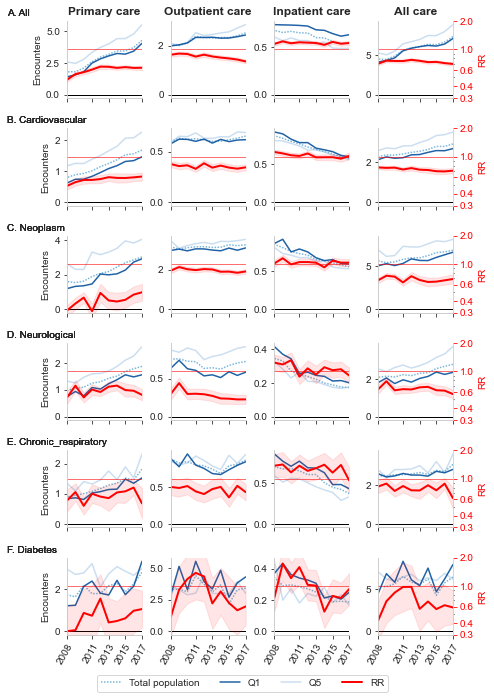

In [370]:
# here only looking at unique encounters

"""
Fig 4
"""

sns.set_style("whitegrid", {'xtick.bottom': True})
#fz = (20, 8) # w, h

resultDicAllDisAllYrsAllOutc ={}
resultDicAllDisAllYrsPC      ={}

gbdNr2namedic ={8:"Neoplasm",9:'Cardiovascular',19:'Musculoskeletal',13:'Mental',12:'Neurological' , 
                10:'Chronic_respiratory' , 15: 'Diabetes', 23: 'Self-harm_violence', 100:'All'}


"""
order of # death 
Cardio
Neopl
Neuro
Chronic resp
Diab
Self har
"""
# när plotta SI- kapa allt innan 2001

#disList =[8,9,12,10, 15,9]#[8,9,12, 10, 15]
disList = [100,9, 8,12,10, 15]  # order of death 23
SESvarName = "DispInkFamLag5_1_r" #"Desoletter"#"Desoletter" DispInkFamLag5_1_r
SESlow =0# 2# "''A' #1#0# #
SEShigh =4 #1#'C' #3# 4#'C'
startYear=2004
#DisNr = 10
axR1col = 'red'
axR2col = 'blue'

nrLinesp1Start =12  # just empitically derived
nrLinesp1End =18
# sf= 0.5
# # 1/2.5
# w = 18*sf
# h= 6*len(disList)*sf

#fig properties
cm2inh = 1/2.54
sf= 1#0.5
w = 18*cm2inh*sf #18*cm2inh*sf
h=  4*cm2inh*len(disList)*sf #21*cm2inh*sf #6*cm2inh*len(disList)*sf
fz = (w, h)
 

BlueLightToDark = ["#eff3ff",
"#c6dbef",
"#9ecae1",
"#6baed6",
"#3182bd",
"#08519c"]

   

c1 = BlueLightToDark[1]  #Q0 unik
c2 = BlueLightToDark[3]  #'yellow' #Tot pop unik
c3 = BlueLightToDark[5]  #'yellow' #Q4 unik
c4 = RedLightToDark[1]  #Q0 visits
c5 = RedLightToDark[3]  # Tot pop visits
c6 = RedLightToDark[5] #Q4 visits
c7 = GreenLightToDark[5] # diff unique Q0-Q4
c8 = RedLightToDark[5] # diff encounters Q0-Q4 ; lw =0.5,ls ='dashed'
c9 = 'red'#RedLightToDark[5] #relative inewualits

cHorRate = 'grey'
# startYr4ORyrTrend = 2005
alphaRates=0.9
alphaOR = 1
alphaHorz =0.8

ORmarker = ''#'|'
#unadjusted OR
c10 = "gold" #"darkviolet"#"#dd1c77" ##fec44f"   #"#bdbdbd"
#
auORmarker = '' 
lwauOR=1 


# line widht and line style parameters
#dif
#lwDif=1.5
lwSDif = 'dashed'

lsAll = (0, (1, 1))#'dotted'#'dashed'
#rates
lwRates= 1.5
lwRatesAll=lwRates
lwOR=2#3
lsOR ='-'
lsUnadjOR = '-'#(0, (4, 2)) #'loosely dashed'
lwUnadjOR =  lwOR

lwHorz =0.7


outcomeList = ["PC_e", "SO_e", "SI_e", "AllHC"]
uniqueOrEnc = 'u'#'e' # or 'u'
uniqueOrEnc2Name = {'e': "encounters", 'u':'unique'}

AlphabeteList =['A. ', 'B. ','C. ','D. ','E. ','F. '] # f
RegNameDic = {'PC_e':'Primary care', "SO_e":'Outpatient care', "SI_e": "Inpatient care", "AllHC": 'All care'}

RegNameDicFile = {'PC_e':'PC_e', "SO_e":'SO_e', "SI_e": "SI_e", "AllHC": 'encAllHC'} # differnt names for All HUC in filenames and in columns.. 
fig,axL = plt.subplots(1*len(disList),len(outcomeList), figsize=(w,h), )

#clear
if "df_result_dis_reg_finial" in globals():
    del df_result_dis_reg_finial

#df_result_dis_reg = pd.DataFrame() 
df_result_dis_reg_finial = pd.DataFrame() 

for r, DisNr in enumerate(disList):
    r1 = r #row index
    d = r
    for c, ov in enumerate(outcomeList):
        n =c #column index
        ov_file = RegNameDicFile[ov]
        fp = r'C:\X\df_result_%s_dis%s_byIncome_last5_june23_v2_NBalph.xlsx' %(ov_file, gbdNr2namedic[DisNr] ) 
        # s_byIncome_last5_june23_v2_NBdefaultAlpha
        # s_byIncome_last5_june23_v2_NBalph
        #'df_result_encAllHC_disNeoplasm_byIncome.xlsx'#
        disNameTemp = re.search('_dis(.*)_byIncome', fp)
        disName = disNameTemp.group(1)
        varNameTemp = re.search('df_result_(.*)_dis', fp)
        varName = varNameTemp.group(1)

        
        df = pd.read_excel(fp)
        

        # number of encounters of Q1 and Q3 relative to Q5 as percentage of the mean (e.g. for total population)
        # percentage of the mean
        COLS = list(df.columns)
        cols_2_exp = [c for c in COLS if not (str(c).startswith("m") or str(c).startswith("year") or str(c).endswith('p'))] #avoid p-values
        #denomCol = 'mEncTot_%s' %(ov) #mEncQ1_PC_e
        df.loc[:,cols_2_exp] = np.exp(df.loc[:,cols_2_exp]) #.div(df.loc[:,denomCol], axis=0)*100 # % change
        df=df[df['year']<2018]
                
     
        axR = axL[r,n].twinx()
        
        

        ylabeln =  'Encounters'#'Per 100 000' #'%s                           \nper 100 000' %(gbdNr2namedic[DisNr]) #               %s\n  Population prevalence (per 100,000) ' %(gbdNr2namedic[DisNr])
        axL[r,0].set_ylabel(ylabeln)
        RowText = '%s%s' %(AlphabeteList[d],gbdNr2namedic[DisNr])
        
        axL[r,0].text(-0.8, 1.1,  RowText, horizontalalignment='left', verticalalignment='center', transform=axL[r1,0].transAxes)


        label1a = "RR" #"Q0"#"Br0m2"
        Q1modelXmean ='Br0m1'
        Q1modelXup = 'Br0m1U'
        Q1modelXlow = 'Br0m1L'
        

        p0, = axR.plot(df.loc[:,'year'],df.loc[:,Q1modelXmean], linestyle='-',label=label1a, lw=LW_ADJ, color = c9)#, marker="o")
        axR.fill_between(df.loc[:,'year'],df.loc[:,Q1modelXup], df.loc[:,Q1modelXlow],  alpha=.1, color = c9)

        Q1encOcX =   "mEncQ1_%s"  %ov # Q1 encounters Outcome X
        QAllencOcX = "mEncTot_%s" %ov 
        Q5encOcX =   "mEncQ5_%s"  %ov 
        
        NrEnc_Q1 = df.loc[:,Q1encOcX]
        NrEnc_all = df.loc[:,QAllencOcX] 
        NrEnc_Q5 = df.loc[:,Q5encOcX]


        #labels
        Q5 = 'Q5, %s' %'Q5'
        
        
        p1, =  axL[r,n].plot(df.loc[:,'year'], NrEnc_Q5, color = c1,#'black',#color7list[n-1], 
                 linewidth=lwRates,  label = 'Q5', alpha=alphaRates )
        # all                       
        p2, = axL[r,n].plot(df.loc[:,'year'], NrEnc_all, color =c2 , linestyle = lsAll,#'black',#color7list[n-1], 
                 linewidth=lwRatesAll,alpha=alphaRates, label ='Total population')#linestyle = 'dotted',  )
        # low                       
        p3, = axL[r,n].plot(df.loc[:,'year'], NrEnc_Q1, color =c3 ,#'black',#color7list[n-1], 
                 linewidth=lwRates, alpha=alphaRates, label = 'Q1' )


        axL[r,n].plot(startYear, 0, color = 'w',#color7list[n-1], 
                 linewidth=1,  label ='', alpha=0.4 )
        axL[r,n].hlines(y = 0, xmin = axL[r1,n].get_xlim()[0],  xmax = axL[r1,n].get_xlim()[1],lw =lwHorz,  alpha = alphaHorz,color = cHorRate )
        
 


        #type some texts
        if r == 0:
            titeltext = '%s' %( RegNameDic[ov])
        else: 
            titeltext = ' '
        axL[r,n].grid(False)
        axL[r,n].set_title(titeltext,weight ='bold')#,size ='smaller' )
        
        axR.set_ylim(0.3,2)
        axR.grid(False)
        axR.set_yscale('log')
        axR.hlines(y = 1 , xmin = axR.get_xlim()[0],  xmax = axR.get_xlim()[1] ,lw =lwHorz,  alpha = alphaHorz, color = c9 )
        axR.spines.top.set_visible(False)
        ylabelnR2 = "RR"
        axR.set_ylabel(ylabelnR2)

        axR.set_yticks([ 0.3,0.4, 0.6,1,2])
        plt.tick_params(axis='y', which='major')
        axR.get_yaxis().set_major_formatter(FormatStrFormatter("%.1f"))


        
        axR.yaxis.label.set_color(c9)
        axR.tick_params(axis='y', colors=c9)
        
        if n  < len(outcomeList)-1:
            axR.yaxis.set_visible(False)
            axR.spines.right.set_visible(False)
            axR.set_xticklabels([])


        #axL[r1,n].get_xlim()
        axL[r,n].set_xticks([2008.0,
             2011.0,
             2013.0,
             2015.0,
             2017.0])
        #[y for y in df2plot_m.index][::2])
        
        if d == len(disList)-1: #last row

            
            axL[r,n].set_xticklabels([2008,
             2011,
             2013,
             2015,
             2017], rotation=90, ha='center' , rotation_mode='anchor')
                
            #[int(y) for y in df2plot_m.index][::3], rotation=65)
        axL[r,n].set_xlim(2008, 2017)
        

        axL[r,n].hlines(y = 0, xmin = axL[r1,n].get_xlim()[0],  xmax = axL[r1,n].get_xlim()[1],lw =1, color = 'black' )
        #axL[r2,n].hlines(y = 1 , xmin = axL[r2,n].get_xlim()[0],  xmax = axL[r2,n].get_xlim()[1] ,lw =1, color = 'black' )
        # Hide the right and top spines
        axL[r,n].spines.right.set_visible(False)
        axL[r,n].spines.top.set_visible(False)
        
        
        #prepp for making table ['Br0m2', 'Br0m2L', 'Br0m2U', 'Br2m2', 'Br2m2L', 'Br2m2U']
        df_result_dis_reg = df.copy()
        df_result_dis_reg['DisNr'] = DisNr
        df_result_dis_reg['ov'] = ov
        df_result_dis_reg_finial = pd.concat([df_result_dis_reg_finial, df_result_dis_reg])#.groupby(by =["DisNr","ov", "year"]).first()  ])
        # end table prepp


lines_labels = [axL.get_legend_handles_labels() for axL in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#new labels and lines

LI =[1,2,3,94] # label index of proper labels,
labels_n =[ labels[i] for i in LI ]
lines_n =[ lines[i] for i in LI ]
        
fig.legend(lines_n, labels_n, ncol=len(labels_n),loc='upper center', bbox_to_anchor=(0.5, 0.010))
  
#plt.subplots_adjust(wspace=0, hspace=0)#(wspace=0.15, hspace=0.15)
fig.autofmt_xdate(rotation=60)
fig.set_size_inches(fz)
fig.tight_layout(pad=1.08, h_pad=None, w_pad=0)
# # close up disease specific graph
#savename = 'Diseases_%s_by_Income_over_time_fromPlotScript.png' %( uniqueOrEnc)
savenamePNG = 'Enc5yrsprior2death.png'# %( uniqueOrEnc)
plt.savefig(savenamePNG , bbox_inches='tight') 


new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)
savenameSVG = 'Enc5yrsprior2death_m1.svg'# %( uniqueOrEnc)
plt.savefig(savenameSVG, format="svg", bbox_inches="tight")#,dpi=300)


plt.show()


# Create table RR at start end and for yearly change

In [339]:
def formatP(p):
    #format p value PLOS med style
    if p < 0.001:
        p_f = '<0.001'
    else: 
        p_f = '{:.3f}'.format(p)
    return p_f

In [424]:
def getSEfromCI(CI_u, CU_l): #, degreesOfF=70):
    """
    Obtain a SE to use for random generation of values N(m, SE)
    CI = m +/- 1.96*SE
    (CI_high -m)/1.96  =  SE
    or
    CI = m +/- 1.96*SE
    ((CI_high -CI_low)/2) /1.96  =  SE
    """
    z_critical = scipy.stats.norm.ppf(q=1-.05/2) # approx 1.96

    SE = ((CI_u - CU_l) / 2 ) / z_critical
    return SE

In [463]:

def logTransformRRAndCreateSEfrom_CI(df,RR_CI_u,RR_CI_l):
    """
    in: 
        - df: dataframe, with cols: year, SE, OR (raw) - i.e. exponated Beta space
    out: 
        - df
            - with 
    """
    y_temp = df['year']
    df.iloc[:,3:] = np.log(df.iloc[:,3:])  # OR CI are symetrical on log(OR), i.e. beta space
    df["SE"] = getSEfromCI(df[RR_CI_u], df[RR_CI_l])
    df['year'] =y_temp
    
    return df

In [426]:
def getBetaYearlyChangeLogRR(df,RR_colName):
    """
    in: 
        - df: dataframe, with cols: year, SE, RR. RR and SE should be in log-RR, thus in linear Beta space
    out: 
        - meanB: beta estimate of linear yearly change of log(RR)
        - lowB : 95% CI lower bound of beta
        - upB  : 95% CI upper bound of beta
    """

    #scipy.stats.t.ppf(q=1-.05/2,df=22)
    df.reset_index(inplace=True)
    b = [] 
    bootstrnr = 1000

    patsyExpr = "%s ~ year " %(RR_colName)
    model_fitted = smf.glm(patsyExpr , data=df ).fit()

    #fig, ax = plt.subplots(1)

    for bootstr in range(0,bootstrnr): # each loop generates new OR_ts to predict
        RR_ts_i = []
        for tp in range(0, len(df[RR_colName])):

            RR_ts_i  = np.append(RR_ts_i, np.random.normal(df[RR_colName][tp],df['SE'][tp],1)[0])
        df['RR_i'] =RR_ts_i
        # mdelfitting in natural log space
        model_fitted = smf.glm('RR_i  ~ year ' , data=df ).fit()
        b0 = model_fitted.params.Intercept  
        b1 = model_fitted.params.year
        RR_ts_i_fitted = b0 + df['year']*b1 # rather OR_ts_i_fitted_logged
        b = np.append(b,b1)

    
    meanB = np.percentile(b,50, axis=0)
    lowB = np.percentile(b, 2.5, axis=0)
    upB = np.percentile(b, 97.5, axis=0)

    
    return meanB,lowB, upB # meanBex, lowBex, upBex #, IRRm,IRRl,IRRu #, df_MeanB_ci #lowB, medianB, upB

In [499]:
disList =[100,9, 8,12,10, 15]
SESvarName = "DispInkFamLag5_1_r" 
SESlow =0# 2# "''A' #1#0# #
SEShigh =4 #1#'C' #3# 4#'C'

#for file paths
modelDicName ={'m0': 'unadjusted' ,'m1': 'adjNoCounty', 'm2':'adjCounty'}


OR_resultTableDf = pd.DataFrame(columns =  ['dis', 'careLevel', 'RR_(CI)_start','RR_start', "RR_(CI)_end",'RR_end_ciOnly',
                                            "RR_end_ciOnly_hl", "RR_end_ciOnly_ll","RR_end", 'B_(CI)_yearly_change_RR', 'B_yearly_change_RR',
                                                   'B_yearly_change_RR_CI_l', 'B_yearly_change_RR_CL_u'])
startYear =2008
endYear =2017

gbdNr2FnameDic ={8:"Neoplasm",9:'Cardiovascular',12:'Neurological' , 
                10:'Chronic_respiratory' , 15: 'Diabetes', 100:'All'}
disList =[100,9, 8,12,10, 15]
outcomeList = ["PC_e", "SO_e", "SI_e","AllHC"]

oc2fNameDic = {"PC_e":"PC_e", "SO_e":"SO_e", "SI_e":"SI_e","AllHC":"encAllHC"}

for modelNr in ['m1','m0', 'm2']:
    # For each model, create one output excel file. Here initiate 

    RR_resultTableDf = pd.DataFrame(columns =  ['disease', 'careLevel',
                                                'RR_(CI)_start','RR_start', 
                                                "RR_(CI)_end",'RR_end_ciOnly',
                                                 "RR_end_ciOnly_hl", "RR_end_ciOnly_ll","RR_end",
                                                'B_(CI)_yearly_change_RR', 'B_yearly_change_RR',
                                                'B_yearly_change_RR_CI_l', 'B_yearly_change_RR_CL_u'])
  
    
    row = 0
    for on, VarOfInt in enumerate(outcomeList): 
    
        for d, DisNr in enumerate(disList[:]):

            """
            df2pl_pc, df2pl_all = load_and_group()
            """
            fp =  r"C:X\df_result_%s_dis%s_byIncome_last5_june23_v2_NBalph.xlsx" %(oc2fNameDic[VarOfInt], gbdNr2FnameDic[DisNr])
            df = pd.read_excel(fp)
            row = row + 1



            #make RR of them
            COLS = list(df.columns)
            cols_2_exp = [c for c in COLS if not (str(c).startswith("m") or str(c).startswith("year") or str(c).endswith('p'))] #avoid p-values
            df.loc[:,cols_2_exp] = np.exp(df.loc[:,cols_2_exp]) #.div(df.loc[:,denomCol], axis=0)*100 # % change
            df=df[df['year']<2018]
            
            #Br0m0	Br0m0L	Br0m0U	Br0m0p
            "Br0%s" %(modelNr)
            # RR 
            RR_U ="Br0%sU" %(modelNr)
            RR_M ="Br0%s"  %(modelNr)
            RR_L ="Br0%sL" %(modelNr)
            RR_p ="Br0%sp" %(modelNr)



            #OrYrTuple
            #AnyRowNr = SES_nr_high # any of 0-4, 55 or 99 works, since identical
            df2plot_RR_CI_h = df.loc[:,RR_U] 
            df2plot_RR_m    = df.loc[:,RR_M]
            df2plot_RR_CI_l = df.loc[:,RR_L] 
            df2plot_RR_p    = df.loc[:,RR_p]

            RR_start_ci = '%.2f [%.2f, %.2f]' %(df.loc[(df.year ==startYear),RR_M].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_L].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_U].iloc[0])
            RR_start_ciOnly = '[%.2f, %.2f]' %(df.loc[(df.year ==startYear),RR_L].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_U].iloc[0])
            RR_start = '%.2f' %(df.loc[(df.year ==startYear),RR_M].iloc[0])
            RR_start_p =  '%.4f' %(df.loc[(df.year ==startYear),RR_p].iloc[0])
            RR_start_p_f =  formatP(df.loc[(df.year ==startYear),RR_p].iloc[0]) 
            
            RR_end_ci = '%.2f [%.2f, %.2f]' %(df.loc[(df.year ==endYear),RR_M].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_L].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_U].iloc[0])
            RR_end_ciOnly = '[%.2f, %.2f]' %(df.loc[(df.year ==endYear),RR_L].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_U].iloc[0])
            RR_end = '%.2f' %(df.loc[(df.year ==endYear),RR_M].iloc[0])
            RR_end_p =  '%.4f' %(df.loc[(df.year ==endYear),RR_p].iloc[0])
            RR_end_p_f =  formatP(df.loc[(df.year ==endYear),RR_p].iloc[0]) 

            RR_end_ciOnly_ll = df.loc[(df.year ==endYear),RR_L].iloc[0]
            RR_end_ciOnly_hl = df.loc[(df.year ==endYear),RR_U].iloc[0]

            # create df_4RRchange 
            df_4RRchange = df.copy()

            # here, omit exponateAndCreateSEfromRR_CI mars20_23
            df_4RRchange = logTransformRRAndCreateSEfrom_CI(df_4RRchange,RR_U,RR_L)

            #b, lowB, upB = getRR_yearlyChange_ci(df_4RRchange) # OLD
            RR_colName =RR_M
            b, lowB, upB = getBetaYearlyChangeLogRR(df_4RRchange,RR_colName)

            D_RR_ci = '%.3f [%.3f, %.3f]' %(b, lowB, upB)
            D_RR_f= '%.3f' %(b)
            D_ci_f = '[%.3f,%.3f]' %(lowB, upB)
            D_RR = b
            D_RR_ci_l = lowB
            D_RR_ci_u = upB
            
            
            
            # feed in table RR_resultTableDf
            RR_resultTableDf.loc[row,'disease'] =  gbdNr2namedic[DisNr]
            RR_resultTableDf.loc[row,'careLevel'] =   VarOfInt

            RR_resultTableDf.loc[row,'RR_(CI)_start'] =   RR_start_ci
            RR_resultTableDf.loc[row,'CI_start'] =   RR_start_ciOnly
            RR_resultTableDf.loc[row,'RR_start'] =   RR_start
            RR_resultTableDf.loc[row,'RR_start_p'] =   RR_start_p
            RR_resultTableDf.loc[row,'RR_start_p_formated'] =  RR_start_p_f

            RR_resultTableDf.loc[row,'RR_(CI)_end'] =   RR_end_ci
            RR_resultTableDf.loc[row,'RR_end_ciOnly'] =   RR_end_ciOnly
            RR_resultTableDf.loc[row,'RR_end'] =   RR_end
            RR_resultTableDf.loc[row,'RR_end_p'] =  RR_end_p
            RR_resultTableDf.loc[row,'RR_end_p_formated'] =  RR_end_p_f

            RR_resultTableDf.loc[row,'RR_end_ciOnly_ll'] =   RR_end_ciOnly_ll
            RR_resultTableDf.loc[row,'RR_end_ciOnly_hl'] =   RR_end_ciOnly_hl

            RR_resultTableDf.loc[row, 'B_(CI)_yearly_change_RR' ]= D_RR_ci
            RR_resultTableDf.loc[row, 'B_yearly_change_RR' ]= D_RR
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_formatted' ]= D_RR_f
            RR_resultTableDf.loc[row, 'B_yearly_change_CI_formatted' ]= D_ci_f
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_CI_l' ]= D_RR_ci_l
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_CL_u' ]= D_RR_ci_u



    #out result TableDf 
    outName = 'DF_%s_resultRR_TableDf.xlsx' %(modelDicName[modelNr])
    RR_resultTableDf.to_excel(outName)
    
    del RR_resultTableDf, row #clear for new model

# make result tables 

In [ ]:
disList =[100,9, 8,12,10, 15] #[8,9,12, 10, 15]
SESvarName = "DispInkFamLag5_1_r" #"Desoletter"#"Desoletter" DispInkFamLag5_1_r
SESlow =0# 2# "''A' #1#0# #
SEShigh =4 #1#'C' #3# 4#'C'

#for file paths
modelDicName ={'m0': 'unadjusted' ,'m1': 'adjNoCounty', 'm2':'adjCounty'}


RR_resultTableDf = pd.DataFrame(columns =  ['dis', 'careLevel', 'Year','TotPop','Q1', "Q5"])
startYear =2008
endYear =2017

gbdNr2FnameDic ={8:"Neoplasm",9:'Cardiovascular',12:'Neurological' , 
                10:'Chronic_respiratory' , 15: 'Diabetes', 100:'All'}
disList =[100,9, 8,12,10, 15]
outcomeList = ["PC_e", "SO_e", "SI_e","AllHC"]

oc2fNameDic = {"PC_e":"PC_e", "SO_e":"SO_e", "SI_e":"SI_e","AllHC":"encAllHC"}

for modelNr in ['m1','m0', 'm2']:
    # For each model, create one output excel file. Here initiate 

    RR_resultTableDf = pd.DataFrame(columns =  ['dis', 'careLevel', 'Year','TotPop','Q1', "Q5"]
  
    
    row = 0
    for on, VarOfInt in enumerate(outcomeList): 
    
        for d, DisNr in enumerate(disList[:]):

            """
            df2pl_pc, df2pl_all = load_and_group()
            """
            fp =  r"X\df_result_%s_dis%s_byIncome_last5_june23_v2_NBalph.xlsx" %(oc2fNameDic[VarOfInt], gbdNr2FnameDic[DisNr])
            df = pd.read_excel(fp)
            row = row + 1



            #make RR of them
            COLS = list(df.columns)
            cols_2_exp = [c for c in COLS if not (str(c).startswith("m") or str(c).startswith("year") or str(c).endswith('p'))] #avoid p-values
            df.loc[:,cols_2_exp] = np.exp(df.loc[:,cols_2_exp]) #.div(df.loc[:,denomCol], axis=0)*100 # % change
            df=df[df['year']<2018]
            
            #Br0m0	Br0m0L	Br0m0U	Br0m0p
            "Br0%s" %(modelNr)
            # RR 
            RR_U ="Br0%sU" %(modelNr)
            RR_M ="Br0%s"  %(modelNr)
            RR_L ="Br0%sL" %(modelNr)
            RR_p ="Br0%sp" %(modelNr)



            #OrYrTuple
            #AnyRowNr = SES_nr_high # any of 0-4, 55 or 99 works, since identical
            df2plot_RR_CI_h = df.loc[:,RR_U] 
            df2plot_RR_m    = df.loc[:,RR_M]
            df2plot_RR_CI_l = df.loc[:,RR_L] 
            df2plot_RR_p    = df.loc[:,RR_p]

            RR_start_ci = '%.2f [%.2f, %.2f]' %(df.loc[(df.year ==startYear),RR_M].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_L].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_U].iloc[0])
            RR_start_ciOnly = '[%.2f, %.2f]' %(df.loc[(df.year ==startYear),RR_L].iloc[0], 
                                                df.loc[(df.year ==startYear),RR_U].iloc[0])
            RR_start = '%.2f' %(df.loc[(df.year ==startYear),RR_M].iloc[0])
            RR_start_p =  '%.4f' %(df.loc[(df.year ==startYear),RR_p].iloc[0])
            RR_start_p_f =  formatP(df.loc[(df.year ==startYear),RR_p].iloc[0]) 
            
            RR_end_ci = '%.2f [%.2f, %.2f]' %(df.loc[(df.year ==endYear),RR_M].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_L].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_U].iloc[0])
            RR_end_ciOnly = '[%.2f, %.2f]' %(df.loc[(df.year ==endYear),RR_L].iloc[0], 
                                            df.loc[(df.year ==endYear),RR_U].iloc[0])
            RR_end = '%.2f' %(df.loc[(df.year ==endYear),RR_M].iloc[0])
            RR_end_p =  '%.4f' %(df.loc[(df.year ==endYear),RR_p].iloc[0])
            RR_end_p_f =  formatP(df.loc[(df.year ==endYear),RR_p].iloc[0]) 

            RR_end_ciOnly_ll = df.loc[(df.year ==endYear),RR_L].iloc[0]
            RR_end_ciOnly_hl = df.loc[(df.year ==endYear),RR_U].iloc[0]

            # create df_4RRchange 
            df_4RRchange = df.copy()

            # here, omit exponateAndCreateSEfromRR_CI mars20_23
            df_4RRchange = logTransformRRAndCreateSEfrom_CI(df_4RRchange,RR_U,RR_L)

            #b, lowB, upB = getRR_yearlyChange_ci(df_4RRchange) # OLD
            RR_colName =RR_M
            b, lowB, upB = getBetaYearlyChangeLogRR(df_4RRchange,RR_colName)

            D_RR_ci = '%.3f [%.3f, %.3f]' %(b, lowB, upB)
            D_RR_f= '%.3f' %(b)
            D_ci_f = '[%.3f,%.3f]' %(lowB, upB)
            D_RR = b
            D_RR_ci_l = lowB
            D_RR_ci_u = upB
            
            
            
            # feed in table RR_resultTableDf
            RR_resultTableDf.loc[row,'disease'] =  gbdNr2namedic[DisNr]
            RR_resultTableDf.loc[row,'careLevel'] =   VarOfInt

            RR_resultTableDf.loc[row,'RR_(CI)_start'] =   RR_start_ci
            RR_resultTableDf.loc[row,'CI_start'] =   RR_start_ciOnly
            RR_resultTableDf.loc[row,'RR_start'] =   RR_start
            RR_resultTableDf.loc[row,'RR_start_p'] =   RR_start_p
            RR_resultTableDf.loc[row,'RR_start_p_formated'] =  RR_start_p_f

            RR_resultTableDf.loc[row,'RR_(CI)_end'] =   RR_end_ci
            RR_resultTableDf.loc[row,'RR_end_ciOnly'] =   RR_end_ciOnly
            RR_resultTableDf.loc[row,'RR_end'] =   RR_end
            RR_resultTableDf.loc[row,'RR_end_p'] =  RR_end_p
            RR_resultTableDf.loc[row,'RR_end_p_formated'] =  RR_end_p_f

            RR_resultTableDf.loc[row,'RR_end_ciOnly_ll'] =   RR_end_ciOnly_ll
            RR_resultTableDf.loc[row,'RR_end_ciOnly_hl'] =   RR_end_ciOnly_hl

            RR_resultTableDf.loc[row, 'B_(CI)_yearly_change_RR' ]= D_RR_ci
            RR_resultTableDf.loc[row, 'B_yearly_change_RR' ]= D_RR
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_formatted' ]= D_RR_f
            RR_resultTableDf.loc[row, 'B_yearly_change_CI_formatted' ]= D_ci_f
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_CI_l' ]= D_RR_ci_l
            RR_resultTableDf.loc[row, 'B_yearly_change_RR_CL_u' ]= D_RR_ci_u



    #out result TableDf 
    outName = 'DF_%s_resultRR_TableDf.xlsx' %(modelDicName[modelNr])
    RR_resultTableDf.to_excel(outName)
    
    del RR_resultTableDf, row #clear for new model

In [ ]:
"""
-select one 3 files pertaining to specific model (m1, m0, m2)

"""
modelNr  = 'm2' # ['m1','m0', 'm2']

name_resultTableDf = 'DF_%s_resultRR_TableDf.xlsx' %(modelDicName[modelNr])


RR_resultTableDf = pd.read_excel(name_resultTableDf)

GB_RR_resultTableDf = RR_resultTableDf.groupby(by=['disease','careLevel']).first()

# alt 1, -via cartesian product
dis = ['All','Cardiovascular', 'Neoplasm','Neurological','Chronic respiratory','DM & CKD']
care= ['AllHC', 'SI_e', 'SO_e', 'PC_e']
indexFromCartesian = pd.MultiIndex.from_product([dis, care], names = ["d", "c"])
GB_RR_resultTableDf = GB_RR_resultTableDf.reindex(index=indexFromCartesian)


['disease', 'careLevel', 'RR_(CI)_start', 'RR_start', 'RR_(CI)_end',
       'RR_end_ciOnly', 'OR_end_ciOnly_hl', 'OR_end_ciOnly_ll', 'OR_end',
       'B_(CI)_yearly_change_OR', 'B_yearly_change_OR',
       'B_yearly_change_OR_CI_l', 'B_yearly_change_OR_CL_u', 'CI_start',
       'OR_start_p', 'OR_start_p_formated', 'CI_end', 'OR_end_p',
       'OR_end_p_formated']

intColsSave = ['RR_(CI)_end', 'RR_end_p_formated', 'RR_(CI)_start','RR_start_p_formated',"B_(CI)_yearly_change_RR" ]


GB_RR_resultTableDf = GB_RR_resultTableDf[intColsSave]


# save table
excelName2save_dGB_RR_resultTableDf = "Table_RR_2017_2004_Delta_by_disNreg_%s_june23.xlsx"  %(modelDicName[modelNr])
GB_RR_resultTableDf.to_excel(excelName2save_dGB_RR_resultTableDf)